# Проект Дашборд конверсий

### Подготовим данные к работе. Импортируем библиотеку Pandas для загрузки и выгрузки данных в формате csv и библиотеку Requests для запроса данных по API

In [153]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
from dotenv import load_dotenv
from pathlib import Path

In [154]:
load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')
print(DATE_END)

2023-09-01


In [155]:
#Отправляем запрос по API для получения визитов по URL
def request_api(date_1, date_2, url):
    data_visit_api = requests.get(f'{url}/visits?begin={date_1}&end={date_2}') 
    visit_json = data_visit_api.json() #Преобразуем данные в объект JSON
    visit_api = pd.DataFrame(visit_json) #преобразуем JSON в DataFrame
   
    #Отправляем запрос по API для получения регистраций по URL
    data_regist_api = requests.get(f'https://data-charts-api.hexlet.app/registrations?begin={date_1}&end={date_2}') 
    regist_json = data_regist_api.json() #Преобразуем данные в объект JSON
    regist_api = pd.DataFrame(regist_json) #преобразуем JSON в DataFrame
    #df_regist_api.head()
    return visit_api, regist_api


df_visit_api, df_regist_api = request_api(DATE_BEGIN, DATE_END, API_URL)
df_regist_api.head()

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 07:40:13 GMT",ebyrd@example.org,web,google,2e0f6bb8-b029-4f45-a786-2b53990d37f1
1,"Wed, 01 Mar 2023 13:14:00 GMT",knightgerald@example.org,web,email,f007f97c-9d8b-48b5-af08-119bb8f6d9b6
2,"Wed, 01 Mar 2023 03:05:50 GMT",cherylthompson@example.com,web,apple,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15
3,"Wed, 01 Mar 2023 00:04:47 GMT",halldavid@example.org,web,email,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60
4,"Wed, 01 Mar 2023 18:31:52 GMT",denise86@example.net,web,google,27f875fc-f8ce-4aeb-8722-0ecb283d0760


### Выполним ряд действий для подсчета уникальных визитов по модели last. 

### Очистим данные визитов

In [156]:
def visits_cleared(df):
    # Убираем дублирующиеся строки
    visit_api_clear = df.drop_duplicates()
    # проверим, есть ли в таблице визиты ботов
    visit_api_clear['user_agent'] =  visit_api_clear['user_agent'].fillna('')
    #Исключим ботов данных применением метода drop() и проверим оставшееся количество строк в датафрейме визитов
    visit_without_bot = df.drop(df[df['user_agent'].str.contains('bot')].index)
    return visit_without_bot

df_visit_without_bot = visits_cleared(df_visit_api)

In [157]:
def unique_visits(df):
    visit_dt = df.copy()
    #df_visit_unique_dt.sort_values(by='datetime', ascending=True)
    #Преобразуем данные в столбце 'datetime' в объект типа datetime64[ns]
    visit_dt['date_group'] = pd.to_datetime(visit_dt['datetime']) #format='%a, %d %b %Y %H:%M:%S GMT')
    #Сортируем по полю 'date_group' в обратном порядке после преобразования в формат datetime64[ns], чтобы сортировка прошла кооректно
    visit_sorted = visit_dt.sort_values(by='date_group', ascending=False)
    # применим функцию drop_duplicates для удаления повторяющихся значений по полю visit_id.
    #По умолчанию функция drop_duplicates() сохранит первый дубликат, поэтому останутся только последние визиты для каждого уникального посетителя.
    visit_unique = visit_sorted.drop_duplicates(subset=['visit_id'])
    return visit_unique
    #df_visit_sorted.head()

df_visit_unique = unique_visits(df_visit_without_bot)
df_visit_unique.head()

,datetime,platform,user_agent,visit_id,date_group
262058,"Thu, 31 Aug 2023 23:52:57 GMT",web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,abf8f308-e4fc-428e-a873-ddc41646a440,2023-08-31 23:52:57
261274,"Thu, 31 Aug 2023 23:52:48 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,f7dea2c9-a5c0-4d71-b6f4-1d2ac7bd9a9c,2023-08-31 23:52:48
261950,"Thu, 31 Aug 2023 23:51:27 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,b0f5c075-0008-4631-8cbc-7e86b5bc7f7e,2023-08-31 23:51:27
262426,"Thu, 31 Aug 2023 23:49:17 GMT",android,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2927323a-977d-432a-b470-6b09d7ed3cc5,2023-08-31 23:49:17
262456,"Thu, 31 Aug 2023 23:48:11 GMT",ios,Mozilla/5.0 (iPhone; CPU iPhone OS 17_0_3 like...,02f7a75d-2445-49b3-90a5-6e1263187881,2023-08-31 23:48:11


In [158]:
def count_unigue_visits(df):
    #С помощью функции dt.strftime() преобразуем datetime в формат даты YYYY-MM-DD
    df['date_group'] = df['date_group'].dt.to_period('D').dt.start_time.dt.date 
    #df_visit_unique_dt.groupby(['datetime', 'platform'], as_index=False).agg({'visit_id': ['count']}) 
    agreegated_visit = df.groupby(['date_group', 'platform']) \
    .size().reset_index(name='visits')
    return agreegated_visit

df_agreegated_visit = count_unigue_visits(df_visit_unique)
df_agreegated_visit.head(552)

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
...,...,...,...
547,2023-08-30,ios,66
548,2023-08-30,web,1227
549,2023-08-31,android,57
550,2023-08-31,ios,50


### Перейдем к подготовке данных по регистрациям

Подготавливаем данные регистраций к работе, убираем дубликаты и заполняем пустые ячейки в platfom. Затем переходим к этапу преобразования datetime и к группировке по дате и платформе и потсчета количества регистраций

In [159]:
def cleared_registrations(df):
    # Убираем дублирующиеся строки
    regist_api_dt = df.drop_duplicates()
    #Заполняем пусные ячейки в столбце platform
    regist_api_dt['platform'] =  regist_api_dt['platform'].fillna('web')
    return regist_api_dt

    

df_regist_api_dt = cleared_registrations(df_regist_api)

In [160]:
def count_registrations(df):
    #Преобразуем данные в столбце 'datetime' в объект типа datetime64[ns]
    df['date_group'] = pd.to_datetime(df['datetime']) # format='%a, %d %b %Y %H:%M:%S GMT'
    #df_regist_api_dt.dtypes
    df.sort_values(by='date_group', ascending=True)
    df['date_group'] = df['date_group'].dt.to_period('D').dt.start_time.dt.date 
    agreegated_regist = df.groupby(['date_group', 'platform']) \
    .size().reset_index(name='registrations')
    return agreegated_regist


df_agreegated_regist = count_registrations(df_regist_api_dt)
df_agreegated_regist.head()

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24


Соединяем таблицы визитов и регистраций

In [161]:
def merged_visit_registration_convarsion(df1, df2):
    merged_conv = pd.merge(df1, df2, on=['date_group', 'platform'])
    # Считаем конверсию визитов в регистрации в процентах и добавляем поле conversion в итоговую таблицу
    merged_conv['conversion'] = (merged_conv['registrations'] / merged_conv['visits']) * 100
#    merged_conv_sort = merged_conv.sort_values(by='date_group', ascending=True)
    #Сохраняем таблицу с конверсиями в формате json
    merged_conv.to_json('./conversion.json')
    # Сгрупируем данные только по дате, исключив группировку по 'platfotm'
    merged_without_platform = merged_conv.copy()
    merged_conv_without_platform = merged_without_platform.groupby(['date_group']).sum(['visits', 'registrations']).reset_index()
    merged_conv_without_platform['conversion'] = (merged_conv_without_platform['registrations'] / merged_conv_without_platform['visits']) * 100
    merged_conv_without_platform.head()
    merged_conv.head()
    return merged_conv, merged_conv_without_platform

df_merged_conv, df_merged_conv_without_platform = merged_visit_registration_convarsion(df_agreegated_visit, df_agreegated_regist)
df_merged_conv_without_platform.head()
df_merged_conv_without_platform_sort = df_merged_conv_without_platform.sort_values(by='conversion', ascending=False)
df_merged_conv_without_platform_sort.head()
#merged_conv_sort = df_merged_conv.sort_values(by='conversion', ascending=False)
df_merged_conv.head(552)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


Загрузим таблицу с затратами на рекламу и отчистим данные

In [162]:
def clean_ads_csv(df):
    df_ads = df.drop_duplicates()
    df_ads['date'] = pd.to_datetime(df['date'])
    df_ads['date'] = df_ads['date'].dt.to_period('D').dt.start_time.dt.date 
    df_ads['utm_campaign'] = df_ads['utm_campaign'].fillna('none')
    df_ads['cost'] = df_ads['cost'].fillna('0')
    #df_ads['ads_campaign'] = df_ads['utm_source'] + '_'  +  df_ads['utm_medium'] + '_' + df_ads['utm_campaign']
    return df_ads

ads = pd.read_csv("./ads.csv")

cleaned_ads = clean_ads_csv(ads)
cleaned_ads.head(200)

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,virtual_reality_workshop,238
1,2023-03-02,google,cpc,virtual_reality_workshop,164
2,2023-03-03,google,cpc,virtual_reality_workshop,240
3,2023-03-04,google,cpc,virtual_reality_workshop,167
4,2023-03-05,google,cpc,virtual_reality_workshop,268
...,...,...,...,...,...
175,2023-09-05,yandex,cpc,cybersecurity_special,221
176,2023-09-06,yandex,cpc,cybersecurity_special,124
177,2023-09-07,yandex,cpc,cybersecurity_special,211
178,2023-09-08,yandex,cpc,cybersecurity_special,195


Сгруппируем затраты на рекламу по дате и рекламной кампании

In [163]:
def df_ads_aggregation(df):

#    df_filter_time = df[(df['date'] >= date1) & (df['date'] <= date2)].copy
    df_agg =  df.groupby(['date', 'utm_campaign']).sum(['cost']).reset_index()
    return df_agg


df_ads_agg = df_ads_aggregation(cleaned_ads)
df_ads_agg.head()

,date,utm_campaign,cost
0,2023-03-01,virtual_reality_workshop,238
1,2023-03-02,virtual_reality_workshop,164
2,2023-03-03,virtual_reality_workshop,240
3,2023-03-04,virtual_reality_workshop,167
4,2023-03-05,virtual_reality_workshop,268


Соединим таблицу конверсий, сагрерированных только по дате, с таблицей затрат на рекламу. Используем левое соединение, чтобы оставить все даты в нужном интервале, даже если затраты на рекламу были нулевыми. Так как соединение левое, то в итоговую таблицу не попадут даты, выходящие за пределы интервала в таблице конверсий

In [164]:
def merge_df_conv_ads(df_conv, df_ads):
    df_conv_end = df_conv.copy()
    df_merged = pd.merge(df_conv_end,  df_ads,
    left_on='date_group',
    right_on='date',
    how='left')
    df_merged.drop('date', axis= 1 , inplace= True)
    df_merged_sort = df_merged.sort_values(by='date_group', ascending=True)
    df_merged_sort = df_merged[['date_group', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]

    df_merged_sort.to_json('./ads.json')
    
    return df_merged_sort

df_merged_conv_ads = merge_df_conv_ads(df_merged_conv_without_platform, df_ads_agg)
df_merged_conv_ads.head(200)
#print(df_merged_conv_ads['ads_campaign'].agg(['nunique']))

,date_group,visits,registrations,conversion,cost,utm_campaign
0,2023-03-01,376,87,23.138298,238.0,virtual_reality_workshop
1,2023-03-02,613,106,17.292007,164.0,virtual_reality_workshop
2,2023-03-03,683,107,15.666179,240.0,virtual_reality_workshop
3,2023-03-04,647,159,24.574961,167.0,virtual_reality_workshop
4,2023-03-05,707,115,16.265912,268.0,virtual_reality_workshop
...,...,...,...,...,...,...
179,2023-08-27,795,88,11.069182,290.0,cybersecurity_special
180,2023-08-28,635,83,13.070866,250.0,cybersecurity_special
181,2023-08-29,1268,143,11.277603,135.0,cybersecurity_special
182,2023-08-30,1328,101,7.605422,130.0,cybersecurity_special


### Перейдем к визуализации

In [165]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy

In [166]:
def weekly_data(df):
    conv_w = df.copy()
    conv_w['date_week'] = pd.to_datetime(conv_w ['date_group'])
    conv_w['date_week'] = conv_w['date_week'].dt.to_period('W').dt.start_time.dt.date
    df_conv_week_platform = conv_w.groupby(['date_week', 'platform']).sum(['visits', 'registrations']).reset_index()
    df_conv_week = conv_w.groupby(['date_week']).sum(['visits', 'registrations']).reset_index()
    df_conv_week_platform['conversion'] = (df_conv_week_platform['registrations'] / df_conv_week_platform['visits']) * 100
    #df_conv_week = df_conv_w[['date_week', 'platform', 'visits', 'registrations']]
    df_conv_week['conversion'] = (df_conv_week['registrations'] / df_conv_week['visits']) * 100
    #df_conv_week.head(200)
    return df_conv_week, df_conv_week_platform

df_conv_week, df_conv_week_platform = weekly_data(df_merged_conv)
df_conv_week.head()

,date_week,visits,registrations,conversion
0,2023-02-27,3026,574,18.968936
1,2023-03-06,8615,1184,13.743471
2,2023-03-13,5215,829,15.896453
3,2023-03-20,3950,664,16.810127
4,2023-03-27,4958,856,17.265026


<Figure size 1400x700 with 0 Axes>

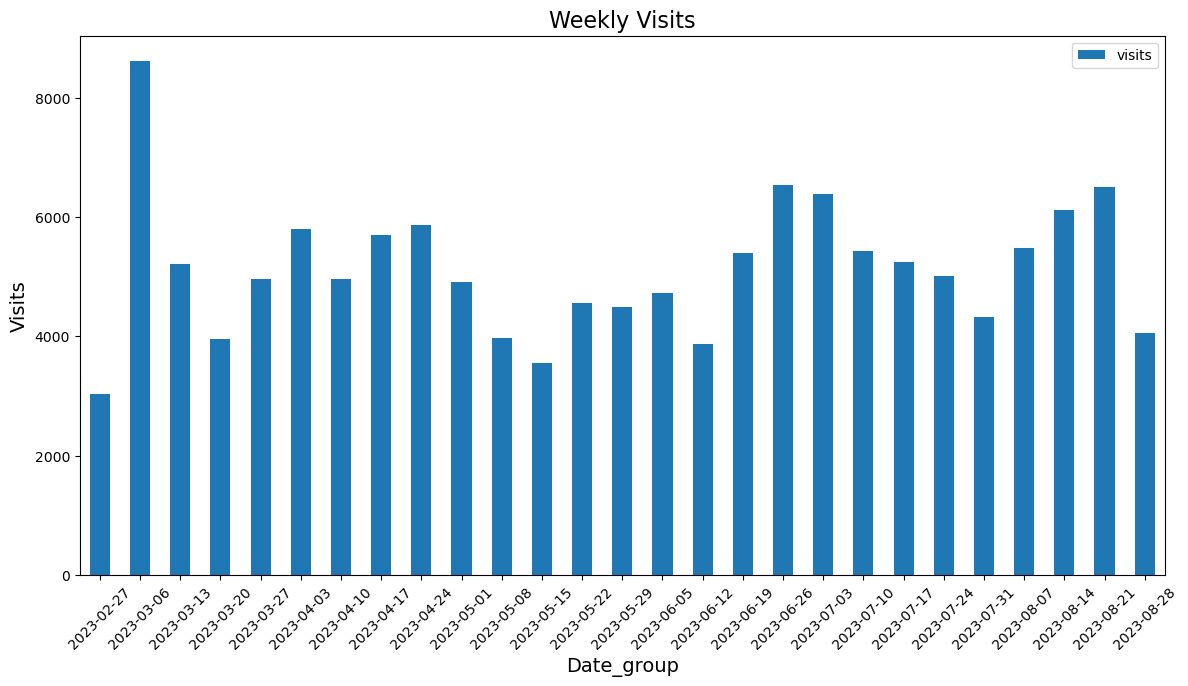

<Figure size 1400x700 with 0 Axes>

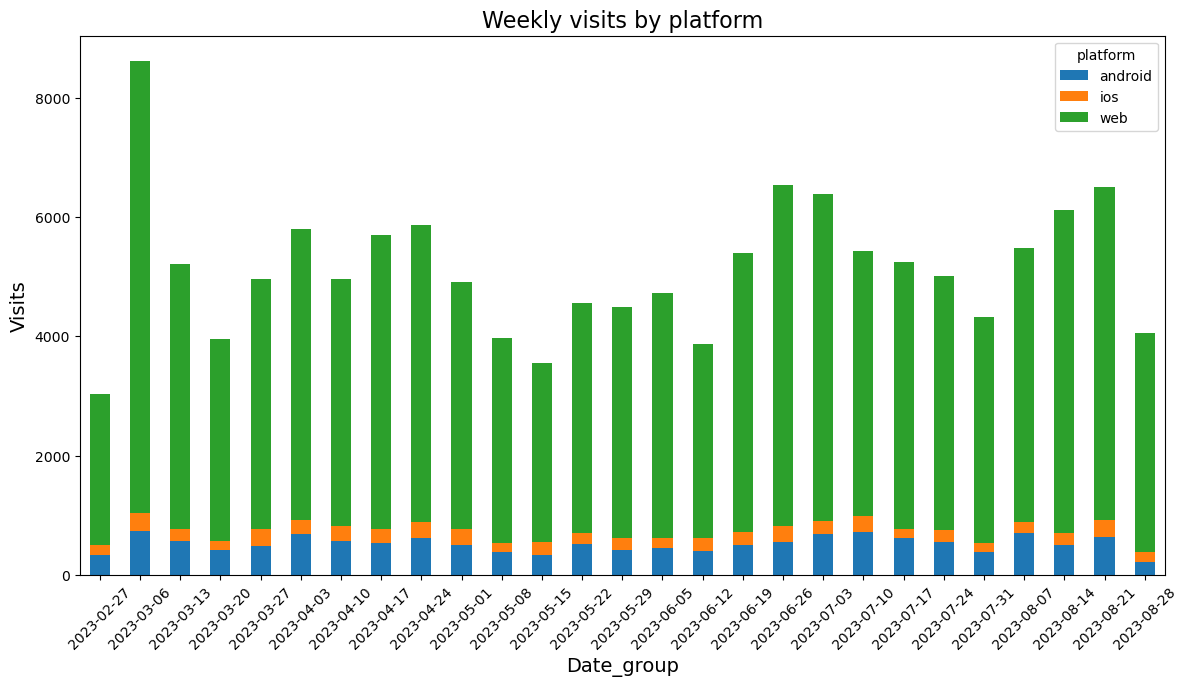

In [167]:
def visualizated_visits(df_w, df_w_p):
        #Create bar chart for weekly visits by date_group without platform 
    plt.figure(figsize=(14, 7))
#    visits_platform = df_w.pivot_table(index='date_week', columns='visits', fill_value=0)
    df_w.plot(kind='bar', y='visits', x='date_week', stacked=False, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly Visits', fontsize=16) # заголовок
    plt.xlabel("Date_group", fontsize=14) # ось абсцисс
    plt.ylabel("Visits", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_Visits.png')
    

    #Create bar chart for weekly visits by date_group and platform
    plt.figure(figsize=(14, 7))
    visits_platform = df_w_p.pivot_table(index='date_week', columns='platform', values='visits', fill_value=0)
    visits_platform.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly visits by platform', fontsize=16) # заголовок
    plt.xlabel("Date_group", fontsize=14) # ось абсцисс
    plt.ylabel("Visits", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_Visits_by_platform.png')

    

visualizated_visits(df_conv_week, df_conv_week_platform)

<Figure size 1400x700 with 0 Axes>

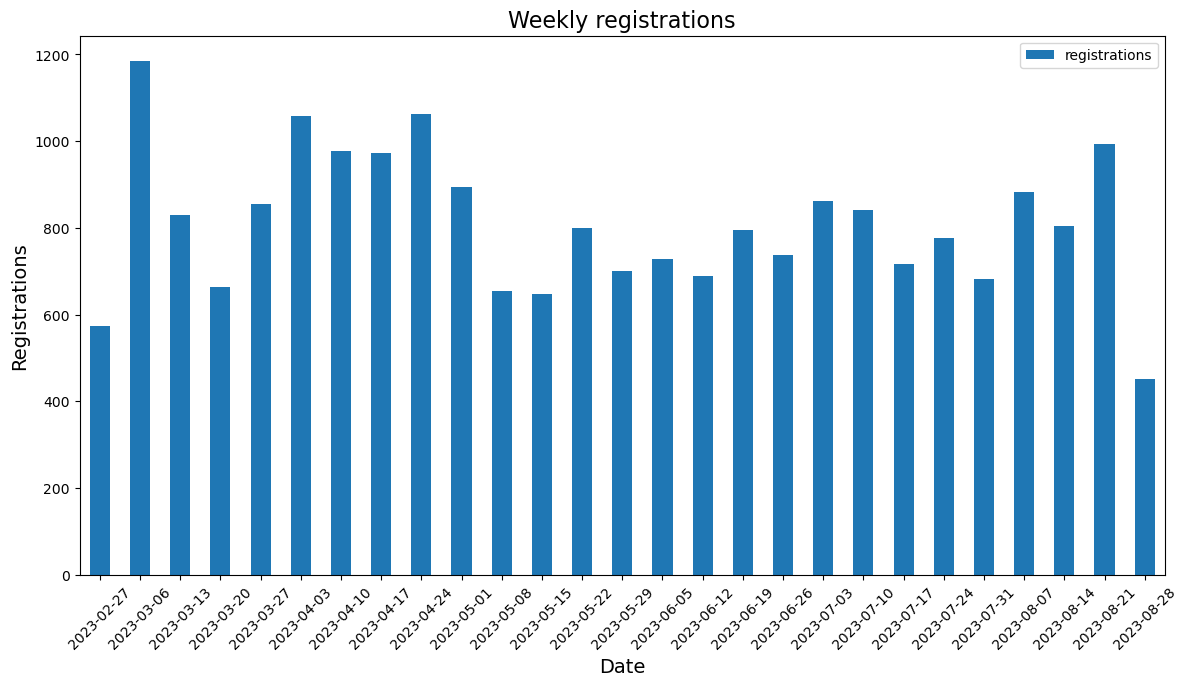

<Figure size 1400x700 with 0 Axes>

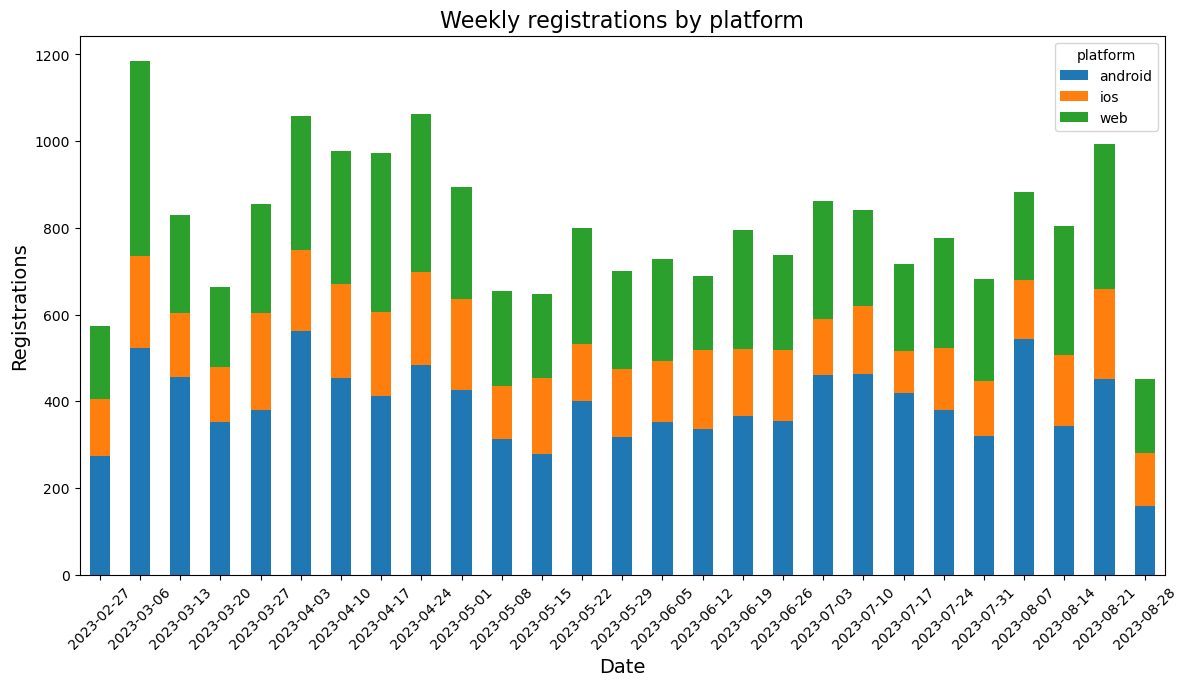

In [168]:
def visualizated_registrations(df_w, df_w_p):
        #Create bar chart for weekly visits by date_group without platform 
    plt.figure(figsize=(14, 7))
#    visits_platform = df_w.pivot_table(index='date_week', columns='visits', fill_value=0)
    df_w.plot(kind='bar', y='registrations', x='date_week', stacked=False, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly registrations', fontsize=16) # заголовок
    plt.xlabel("Date", fontsize=14) # ось абсцисс
    plt.ylabel("Registrations", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_registrations.png')
    

    #Create bar chart for weekly visits by date_group and platform
    plt.figure(figsize=(14, 7))
    visits_platform = df_w_p.pivot_table(index='date_week', columns='platform', values='registrations', fill_value=0)
    visits_platform.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly registrations by platform', fontsize=16) # заголовок
    plt.xlabel("Date", fontsize=14) # ось абсцисс
    plt.ylabel("Registrations", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_registrations_by_platform.png')

visualizated_registrations(df_conv_week, df_conv_week_platform)

<Figure size 1400x700 with 0 Axes>

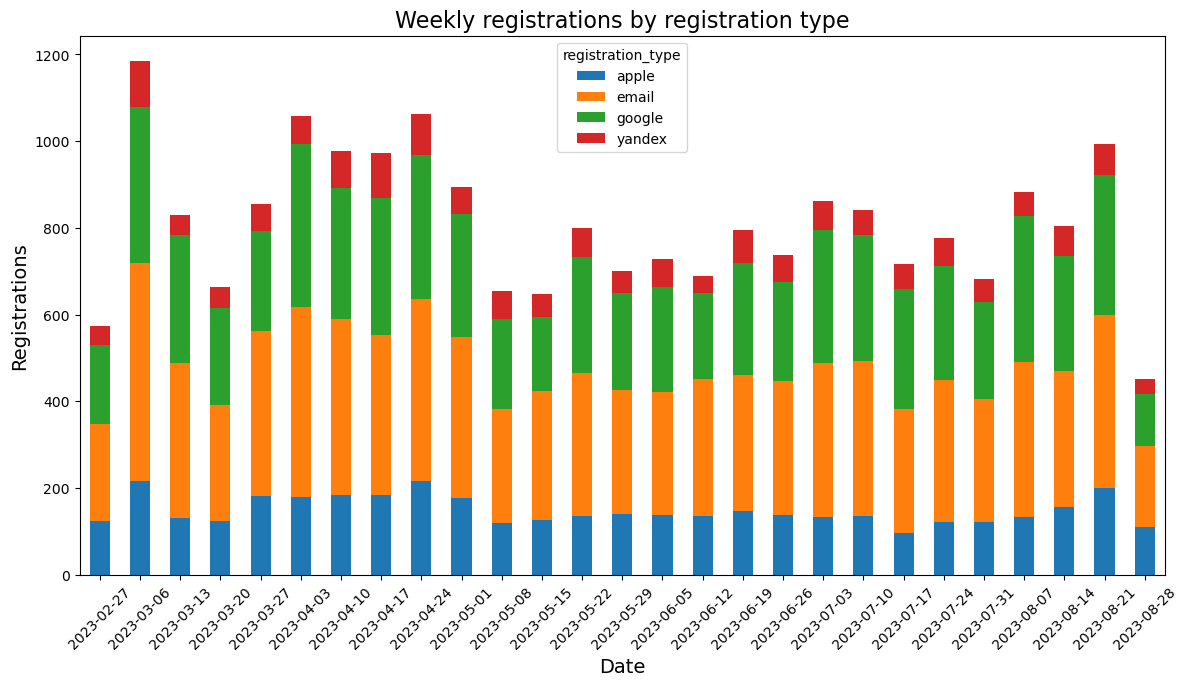

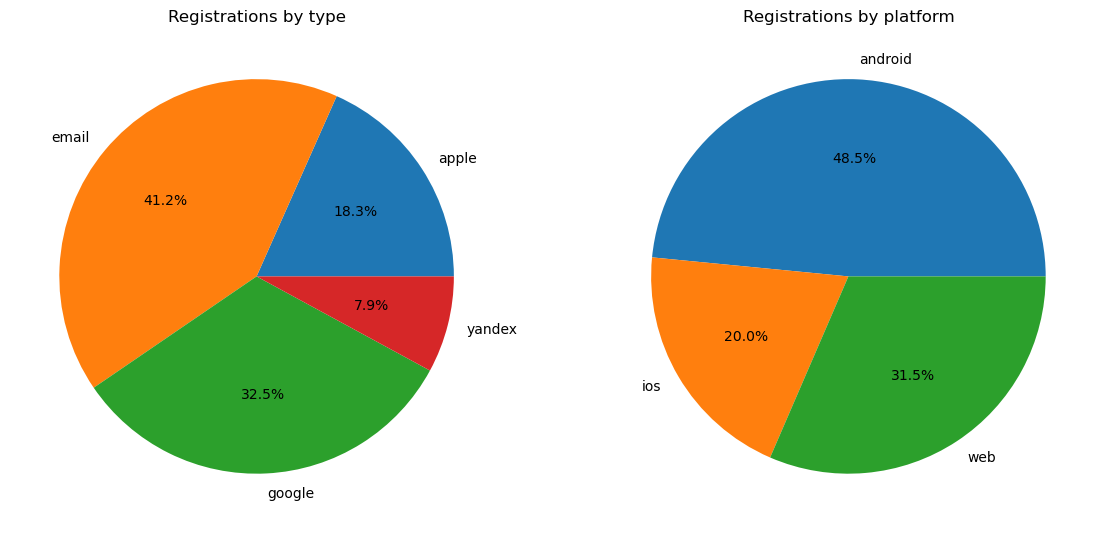

In [169]:
def visualizated_registrations_by_type(df):
    # Подготавливаем таблицу с регистрациями в зависимости от типа регистрации
    regist_type = df.copy()
    regist_type['date_week'] = pd.to_datetime(regist_type['date_group'])
    regist_type['date_week'] = regist_type['date_week'].dt.to_period('W').dt.start_time.dt.date
    df_regist_type = regist_type.groupby(['date_week', 'registration_type']) \
    .size().reset_index(name='registrations')

     #Create bar chart for weekly registrations by registration type
    plt.figure(figsize=(14, 7))
    plt_regist_type = df_regist_type.pivot_table(index='date_week', columns='registration_type', values='registrations', fill_value=0)
    plt_regist_type.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.xticks(rotation=45)
    plt.title('Weekly registrations by registration type', fontsize=16) # заголовок
    plt.xlabel("Date", fontsize=14) # ось абсцисс
    plt.ylabel("Registrations", fontsize=14) # ось ординат
    plt.savefig(f'./charts/Weekly_registrations_by_type.png')

    #Create pie chart for total registrations by registration type and platform
    regist_type_pie = df.groupby(['registration_type']).size().reset_index(name='registrations')  
    regist_platform_pie = df.groupby(['platform']).size().reset_index(name='registrations') 
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].pie(regist_type_pie['registrations'], labels=regist_type_pie['registration_type'], autopct='%1.1f%%')
    ax[1].pie(regist_platform_pie['registrations'], labels=regist_platform_pie['platform'], autopct='%1.1f%%')
    ax[0].set_title('Registrations by type')
    ax[1].set_title('Registrations by platform')
    #plt.tight_layout()
    plt.savefig(f'./charts/registrations_pies.png')

visualizated_registrations_by_type(df_regist_api_dt)

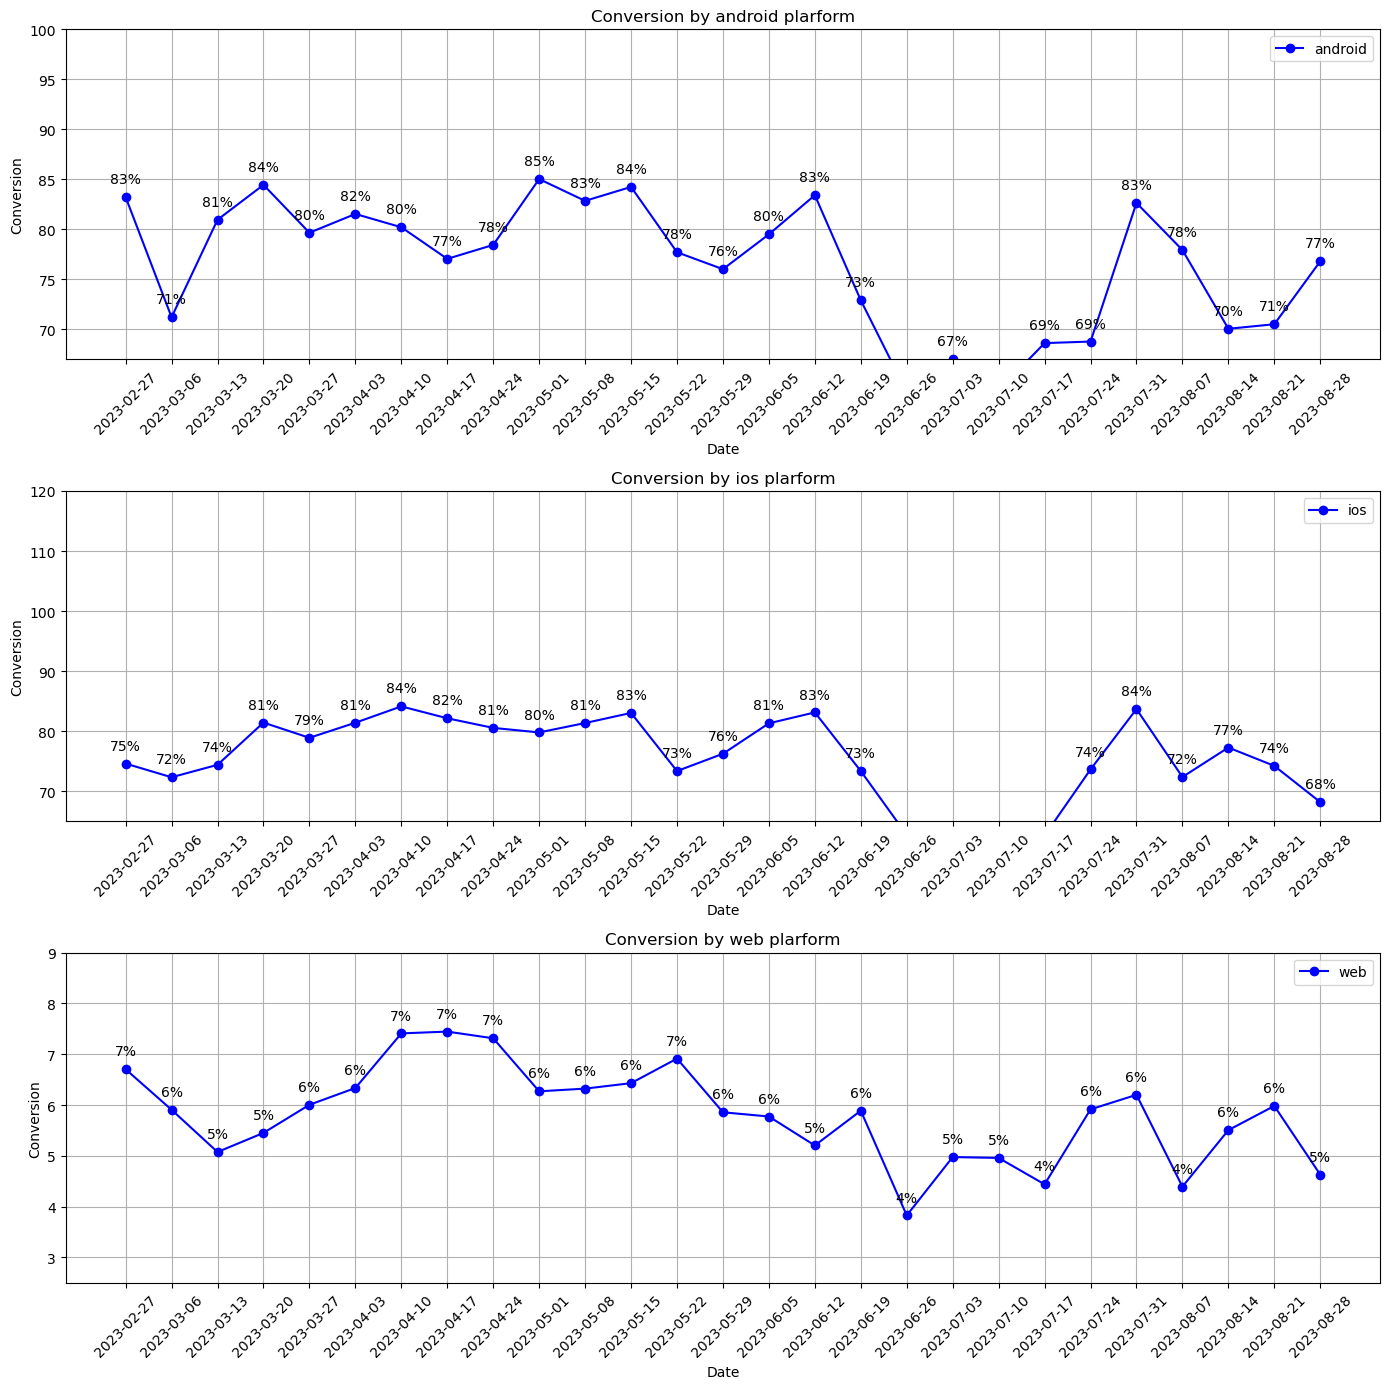

In [170]:
def visualizated_conversion_by_platform(df):
    plt_conv_by_platform = df.pivot_table(index='date_week', columns='platform', values='conversion', fill_value=0)
    plt_conv_by_platform.reset_index(inplace=True)
    fig, ax = plt.subplots(3, 1, figsize=(14, 14))
    ax[0].plot(plt_conv_by_platform['date_week'], plt_conv_by_platform['android'], marker='o', c='b', label='android')
    x0 = plt_conv_by_platform['date_week']
    y0 = plt_conv_by_platform['android']
    for x0,y0 in zip(x0,y0):
        label = "{:.0f}%".format(y0)
        ax[0].annotate(label, (x0,y0), textcoords="offset points",  xytext=(0,10), ha='center')
    ax[0].legend()
    ax[0].set_title('Conversion by android plarform')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Conversion')
    ax[0].set_xticks(plt_conv_by_platform['date_week'])
    ax[0].set_xticklabels(plt_conv_by_platform['date_week'], rotation=45)
    ax[0].set_ylim([67, 100])
    ax[0].grid()
    
    ax[1].plot(plt_conv_by_platform['date_week'], plt_conv_by_platform['ios'], marker='o', c='b', label='ios')
    x1 = plt_conv_by_platform['date_week']
    y1 = plt_conv_by_platform['ios']
    for x1,y1 in zip(x1,y1):
        label = "{:.0f}%".format(y1)
        ax[1].annotate(label, (x1,y1), textcoords="offset points",  xytext=(0,10), ha='center')
    ax[1].legend()
    ax[1].set_title('Conversion by ios plarform')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Conversion')
    ax[1].set_xticks(plt_conv_by_platform['date_week'])
    ax[1].set_xticklabels(plt_conv_by_platform['date_week'], rotation=45)
    ax[1].set_ylim([65, 120])
    ax[1].grid()
    
    ax[2].plot(plt_conv_by_platform['date_week'], plt_conv_by_platform['web'], marker='o', c='b', label='web')
    x2 = plt_conv_by_platform['date_week']
    y2 = plt_conv_by_platform['web']
    for x2,y2 in zip(x2,y2):
        label = "{:.0f}%".format(y2)
        ax[2].annotate(label, (x2,y2), textcoords="offset points",  xytext=(0,10), ha='center')
    ax[2].legend()
    ax[2].set_title('Conversion by web plarform')
    ax[2].set_xlabel('Date')
    ax[2].set_ylabel('Conversion')
    ax[2].set_xticks(plt_conv_by_platform['date_week'])
    ax[2].set_xticklabels(plt_conv_by_platform['date_week'], rotation=45)
    ax[2].set_ylim([2.5, 9])
    ax[2].grid()
    
    plt.tight_layout()
    plt.savefig(f'./charts/conversion_by_platform.png')


visualizated_conversion_by_platform(df_conv_week_platform)

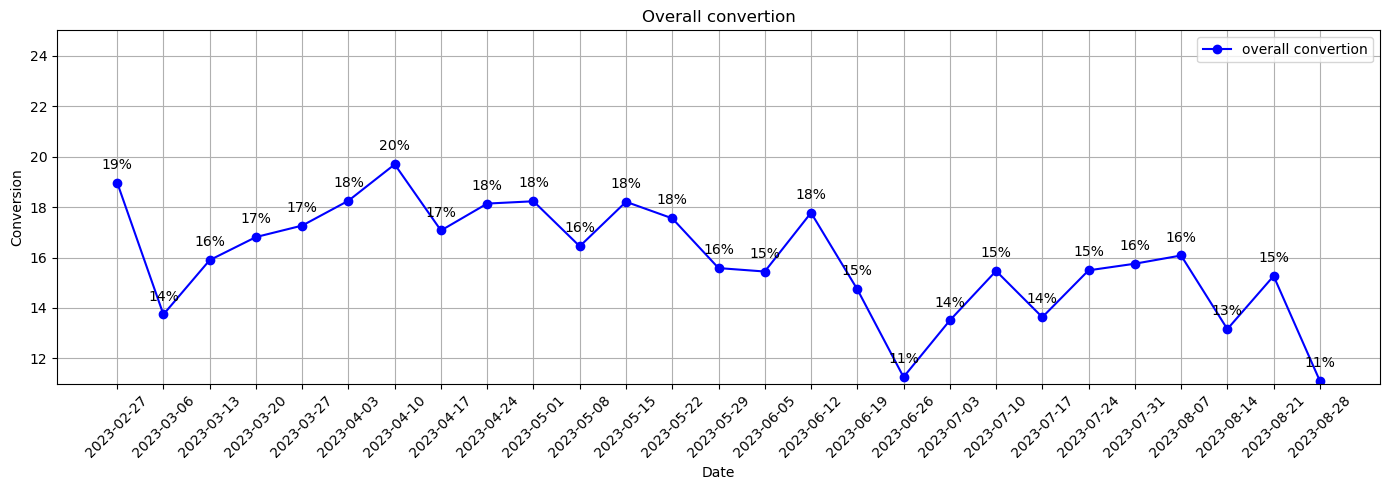

In [171]:
def visualizated_full_conversion(df):
    #Create plot chart for weekly overall convertion
    plt.figure(figsize=(14, 5))
    plt.plot(df['date_week'], df['conversion'], marker='o', c='b', label='overall convertion')
    x0 = df['date_week']
    y0 = df['conversion']
    for x0,y0 in zip(x0,y0):
        label = "{:.0f}%".format(y0)
        plt.annotate(label, (x0,y0), textcoords="offset points",  xytext=(0,10), ha='center')
    plt.legend()
    plt.title('Overall convertion')
    plt.xlabel('Date')
    plt.ylabel('Conversion')
    plt.xticks(df['date_week'], rotation=45)
    plt.ylim([11, 25])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'./charts/weekly_overall_conversion.png')


visualizated_full_conversion(df_conv_week)    

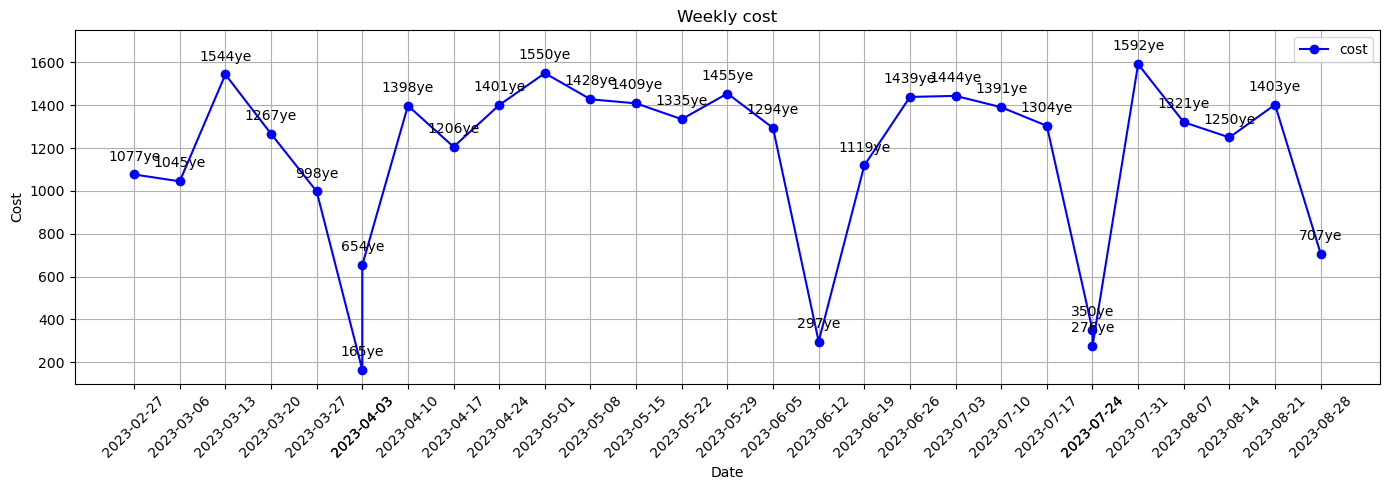

In [172]:
def visualizated_cost(df):
    conv_cost_week = df.copy()
    conv_cost_week['date_week'] = pd.to_datetime(conv_cost_week['date_group'])
    conv_cost_week['date_week'] = conv_cost_week['date_week'].dt.to_period('W').dt.start_time.dt.date
    df_conv_cost_week = conv_cost_week.groupby(['date_week', 'utm_campaign']).sum(['visits', 'registrations', 'cost']).reset_index()
    df_conv_cost_week['conversion'] = (df_conv_cost_week['registrations'] / df_conv_cost_week['visits']) * 100
    df_conv_cost_week.head()
    
    plt.figure(figsize=(14, 5))
    plt.plot(df_conv_cost_week['date_week'], df_conv_cost_week['cost'], marker='o', c='b', label='cost')
    x0 = df_conv_cost_week['date_week']
    y0 = df_conv_cost_week['cost']
    for x0,y0 in zip(x0,y0):
        label = "{:.0f}уе".format(y0)
        plt.annotate(label, (x0,y0), textcoords="offset points",  xytext=(0,10), ha='center')
    plt.legend()
    
    plt.title('Weekly cost')
    plt.xlabel('Date')
    plt.ylabel('Cost')
    plt.xticks(df_conv_cost_week['date_week'], rotation=45)
    plt.ylim([100, 1750])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'./charts/weekly_cost.png')


visualizated_cost(df_merged_conv_ads)    

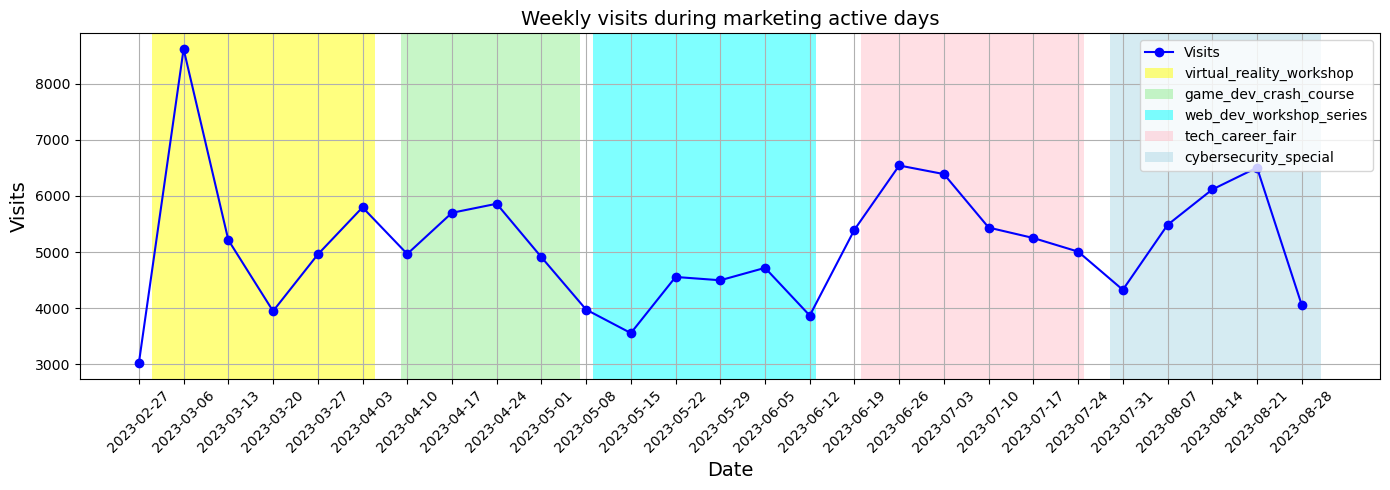

In [173]:
def visualizated_visits_with_active_marketing(df, df_week):
    conv_ads_campaign1 = df[df["utm_campaign"] == "cybersecurity_special"]
    conv_ads_campaign2 = df[df["utm_campaign"] == "game_dev_crash_course"]
    conv_ads_campaign3 = df[df["utm_campaign"] == "tech_career_fair"]
    conv_ads_campaign4 = df[df["utm_campaign"] == "virtual_reality_workshop"]
    conv_ads_campaign5 = df[df["utm_campaign"] == "web_dev_workshop_series"]
        
    plt.figure(figsize=(14, 5))
        
    plt.plot(df_week['date_week'], df_week['visits'], marker='o', c='b', label='Visits') 
    plt.axvspan(conv_ads_campaign4['date_group'].min(), conv_ads_campaign4['date_group'].max(), facecolor='yellow', alpha=0.5, label='virtual_reality_workshop')
    plt.axvspan(conv_ads_campaign2['date_group'].min(), conv_ads_campaign2['date_group'].max(), facecolor='lightgreen', alpha=0.5, label='game_dev_crash_course')
    plt.axvspan(conv_ads_campaign5['date_group'].min(), conv_ads_campaign5['date_group'].max(), facecolor='cyan', alpha=0.5, label='web_dev_workshop_series')
    plt.axvspan(conv_ads_campaign3['date_group'].min(), conv_ads_campaign3['date_group'].max(), facecolor='pink', alpha=0.5, label='tech_career_fair')
    plt.axvspan(conv_ads_campaign1['date_group'].min(), conv_ads_campaign1['date_group'].max(), facecolor='lightblue', alpha=0.5, label='cybersecurity_special')
    
    plt.xticks(df_week['date_week'], rotation=45)
    plt.legend(loc='upper right')
    plt.title('Weekly visits during marketing active days', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Visits', fontsize=14)
    plt.grid()

    
    plt.tight_layout()
    plt.savefig(f'./charts/Weekly_visits_with_active_marketing.png')
    

visualizated_visits_with_active_marketing(df_merged_conv_ads, df_conv_week)

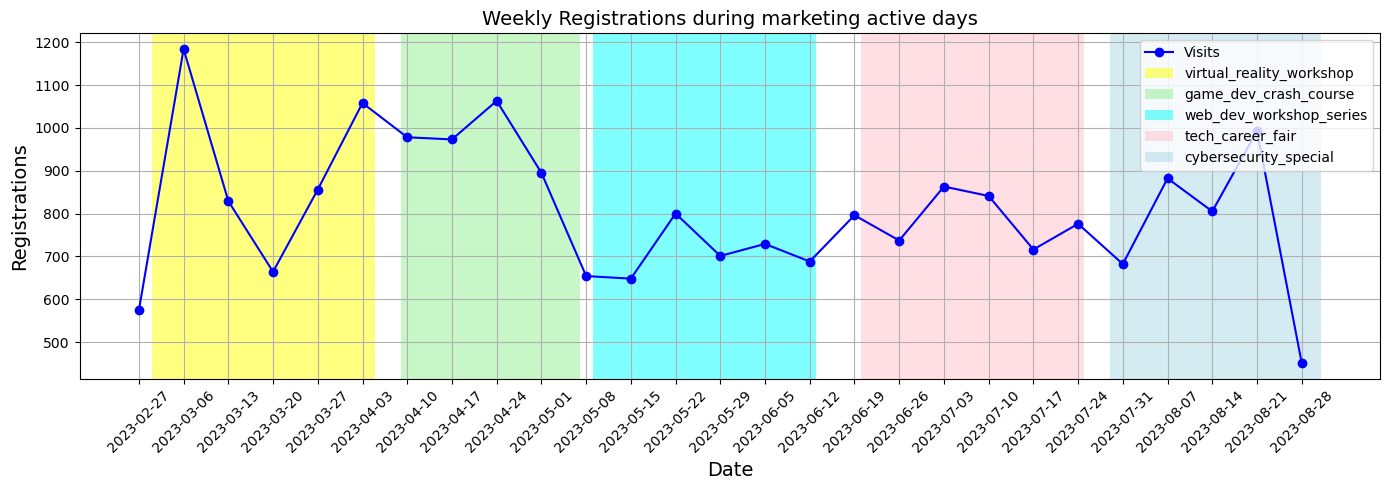

In [174]:
def visualizated_registrations_with_active_marketing(df, df_week):
    conv_ads_campaign1 = df[df["utm_campaign"] == "cybersecurity_special"]
    conv_ads_campaign2 = df[df["utm_campaign"] == "game_dev_crash_course"]
    conv_ads_campaign3 = df[df["utm_campaign"] == "tech_career_fair"]
    conv_ads_campaign4 = df[df["utm_campaign"] == "virtual_reality_workshop"]
    conv_ads_campaign5 = df[df["utm_campaign"] == "web_dev_workshop_series"]
        
    plt.figure(figsize=(14, 5))
    plt.title("Weekly Registrations during marketing active days", fontsize=14)
    
    plt.plot(df_week['date_week'], df_week['registrations'], marker='o', c='b', label='Visits') 
    plt.axvspan(conv_ads_campaign4['date_group'].min(), conv_ads_campaign4['date_group'].max(), facecolor='yellow', alpha=0.5, label='virtual_reality_workshop')
    plt.axvspan(conv_ads_campaign2['date_group'].min(), conv_ads_campaign2['date_group'].max(), facecolor='lightgreen', alpha=0.5, label='game_dev_crash_course')
    plt.axvspan(conv_ads_campaign5['date_group'].min(), conv_ads_campaign5['date_group'].max(), facecolor='cyan', alpha=0.5, label='web_dev_workshop_series')
    plt.axvspan(conv_ads_campaign3['date_group'].min(), conv_ads_campaign3['date_group'].max(), facecolor='pink', alpha=0.5, label='tech_career_fair')
    plt.axvspan(conv_ads_campaign1['date_group'].min(), conv_ads_campaign1['date_group'].max(), facecolor='lightblue', alpha=0.5, label='cybersecurity_special')
    
    plt.xticks(df_week['date_week'], rotation=45)  
    plt.legend(loc='upper right')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Registrations', fontsize=14)
    plt.grid()
       
    plt.tight_layout()
    plt.savefig(f'./charts/Weekly_registrations_with_active_marketing.png')
    

visualizated_registrations_with_active_marketing(df_merged_conv_ads, df_conv_week)